In [ ]:
from data_process import file2index,name2index
import os
from config import config
name2idx = name2index(config.arrythmia)
file2idx = file2index(config.alldata_label,name2idx)
for key,value in file2idx.items():
    if not len(value) == 1:
        print(key)

In [12]:
#预测测试
import numpy as np

a = np.array([1,2,3])
b = np.array([3,4,5])
d = np.zeros_like(b)
c = a*b
print(d)

[0 0 0]


(750,)
1709995.xml-947.npy
窦性心律


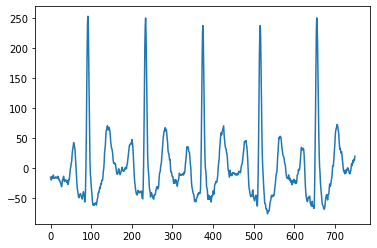

In [68]:
#检查重采样后的数据与原数据
# 1719968、
import matplotlib.pyplot as plt
import os
import numpy as np
from config import config
data_list = []
label_list = []
import random
for data_name in open('D://Data/Heartbeat/shuchuang/sczaobo_label_v1_1217.txt','r'):
    data = data_name.strip().split(',')
    data_list.append(data[0]+'.npy')
    label_list.append(data[1])
rand = random.randint(0,len(label_list))
x = np.load(os.path.join('D://Data/Heartbeat/shuchuang/zaobo_v2.1',data_list[rand]))
print(x.shape)
print(data_list[rand])
label = label_list[rand]
print(label)
plt.plot(x)
##按照原始的方案把200703073896-阵发性室上性心动过速处理一遍，看1540是不是采样点，图片是否一致

[]
[80, 123, 184]
[41, 196]


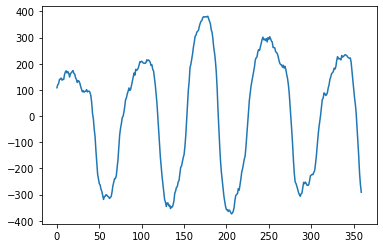

In [9]:
from U_net.CMI_ECG_segmentation_CNV2 import CBR_1D,Unet_1D
from data_process import resample,output_sliding_voting,U_net_peak,U_net_RPEAK
import os
import matplotlib.pylab as plt
import time
import torch
import numpy as np
from scipy import signal
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Unet = torch.load('U_net/240HZ_t+c_v2_best.pt',map_location=device)
data = np.load('D://Data//Heartbeat//mve//mve_npydata_v1//mve_419_rawidx27621_27996.npy')
p,N,t,r = U_net_peak(data[0],input_fs=240,model=Unet)
r_list = U_net_RPEAK(N)
p_list = U_net_RPEAK(p)
t_list = U_net_RPEAK(t)
print(r_list)
print(p_list)
print(t_list)
plt.plot(data[0])

for i in r_list:
    plt.plot(i,data[0][i],'o')

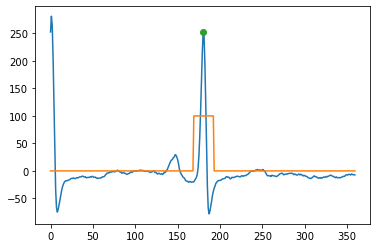

In [1]:

from U_net.CMI_ECG_segmentation_CNV2 import CBR_1D,Unet_1D
from data_process import R_Detection_U_net,resample,output_sliding_voting,U_net_peak,U_net_RPEAK
import os
import matplotlib.pylab as plt
import time
import torch
import numpy as np
from scipy import signal
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Unet = torch.load('U_net/240HZ_t+c_v2_best.pt',map_location=device)
data = np.load('D://Data//Heartbeat//shuchuang//zaobo_v2.1//1657631.xml-1896.npy')
# data = np.load('D://Data//Heartbeat//noise//noise_npydata_v1//noise_ma_l0_rawidx2160_2700.npy')[0]
# data = np.load('D://Project//ECG_neo4j//ECG_AI//data//Total12W//alldata_npy//1662760.xml.npy')[1]
with torch.no_grad():
    p,N,t,r = U_net_peak(data,input_fs=240,model=Unet)
    x_axios = range(0,len(data))
    R_list = R_Detection_U_net(data,N)
    plt.plot(x_axios,data[x_axios])
    plt.plot(x_axios,(N*100)[x_axios])
for i in R_list:
    if i in x_axios:
        plt.plot(i,data[i],'o')

In [9]:
import tqdm
# pbar = tqdm.tqdm(total=100)
#
# pbar.update(10)
# pbar.close()

import numpy as np
a = [1,2,4,7,11]
a = np.insert(a,len(a),13)
for i,v in enumerate(a):
    if v==4:
        a = np.insert(a,i+1,5)
        a = np.insert(a,i+2,6)
    print(v)
print(a)

1
2
4
7
11
13
[ 1  2  4  5  6  7 11 13]


In [6]:
from scipy import stats
nums = [1,2,3,4,5,6,6]
print(stats.mode(nums)[0][0])
print(int(5/2))

6
2


In [1]:
#检查分类结果
from config import config
import numpy as np
import os
from analyze_24h_xintiao250HZ import load_mybeats
from data_process import BSW,resample,name2index
from dataset import transform
import random
import torch
import models
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = config.dir_24h
Resnet = getattr(models, config.model_name)(num_classes=config.num_classes)
Resnet.load_state_dict(torch.load(
    os.path.join('ckpt/resnet34_cbam_ch1_202112181814_v1_lr1e-3_st16_32_64_warmup1e-5-8_bsz1280.005mv',
                 'best_w.pth'),
    map_location='cpu')['state_dict'])
Resnet = Resnet.to(device)
Resnet.eval()
name2idx = name2index(config.arrythmia)
idx2name = {idx: name for name, idx in name2idx.items()}
for data_name in os.listdir(data_path):
    if not data_name[0] == '2':
        continue
    fin = open(os.path.join(data_path, data_name),encoding='utf-8')
    data = list(map(float, fin.readline().strip().strip(',').split(',')))
    fin.close()
    data = np.array(data)
    mybeats = load_mybeats(data_name[0]+'_mybeats_withlabel.txt',config.mybeats_24h)
    sample = random.randint(0,len(mybeats))
    mybeat = mybeats[sample]
    data = resample(data,len(data)*240//250)
    data = BSW(data,fs = 240)
    x_axios = range(int(mybeat.position-0.75 * 240),int(mybeat.position + 0.75 * 240))
    start = 14604049
    x_axios = range(int(start-0.75 * 240),int(start + 0.75 * 240))
    x = data[x_axios]
    x = BSW(x,0.5,fs = 240)
    plt.plot(x)
    plt.plot(int(len(x)/2),x[int(len(x)/2)],'o',color = 'k')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()
    with torch.no_grad():
        x = np.reshape(x,(1,360))
        x.astype(np.float32)
        if config.data_standardization:
            x = (x-np.mean(x))/np.std(x)
        # x = x * config.inputUnit_uv / config.targetUnit_uv
         # 符值转换
        x = x.T
        x = transform(x).unsqueeze(0).to(device)
        output = torch.softmax(Resnet(x), dim=1).squeeze()
        output = torch.softmax(output, dim=0, dtype=torch.float32)
        y_pred = torch.argmax(output, dim=0, keepdim=False)
        y_pred = y_pred.item()
        print("推理结果：{}".format(idx2name[y_pred]))

    print("心拍位置：{}".format(mybeat.position))
    print("原始结果：{}".format(mybeat.label))
    break

D:\Project\ECG_24h\models\resnet_cbam.py:138: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
D:\Project\ECG_24h\models\resnet_cbam.py:142: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


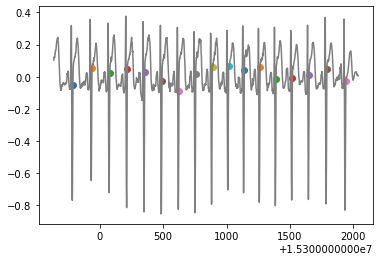

In [11]:
#检查心拍位置
from config import config
import numpy as np
import os
from data_process import U_net_peak
from analyze_24h_xintiao250HZ import load_mybeats
from data_process import BSW,resample
import random
import torch
from U_net.CMI_ECG_segmentation_CNV2 import Unet_1D,CBR_1D
import matplotlib.pyplot as plt
data_path = config.dir_24h
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    Unet = torch.load('U_net/240HZ_t+c_v2_best.pt', map_location=device)
    Unet.eval()
    for data_name in os.listdir(data_path):
        if not data_name[0] == '1':
            continue
        beats_in = open(os.path.join(config.beats_24h,data_name[0]+'-beats.txt'))
        beats = beats_in.readline().split(',')[1:]
        fin = open(os.path.join(data_path, data_name),encoding='utf-8')
        data = list(map(float, fin.readline().strip().strip(',').split(',')))
        fin.close()
        data = resample(data,len(data)*240//250)
        start = random.randint(0,len(data)*240//250)
        # start = 16750000
        x_axios = range(start,start+2400)
        x = data[x_axios]
        # q,N,t,r = U_net_peak(x,in)
        data = np.array(data)

        for i in beats:
            i = int(i)
            if i in x_axios:
                plt.plot(i,data[i],'o')

        plt.plot(x_axios,data[x_axios])
        plt.show()

        break

D:\Environment\Anaconda\envs\ECG_wave\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


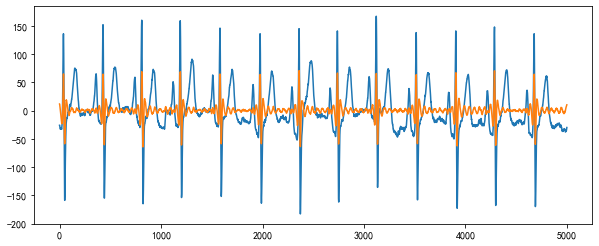

In [1]:
# 傅里叶、小波

import numpy as np
from scipy.fftpack import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
mpl.rcParams['axes.unicode_minus']=False  # 显示负号
from config import config
import os
plt.figure(figsize=(10,4))
fs = 500
l = 10
signal = np.load('D://Project//ECG_neo4j//ECG_AI//data//Total12W//alldata_npy//1657628.xml.npy')[1]
plt.plot(signal)
y = fft(signal)
fr = np.array(range(0,len(signal)))/10
region = (int)(len(fr)/2)
for index,_ in enumerate(y):
    if not 100 < index < 2000:
        y[index] = 0
signal_ifft = ifft(y)
plt.plot(signal_ifft)
plt.show()
plt.close()
# plt.plot(abs(y)[:500])
# plt.plot(x)

70
5


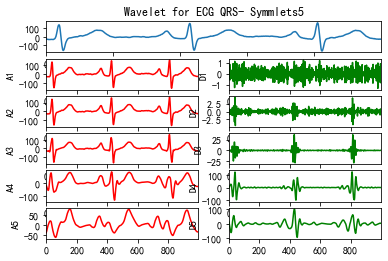

In [49]:
# wavelet
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


ecg = np.load('D://Project//ECG_neo4j//ECG_AI//data//Total12W//alldata_npy//1657628.xml.npy')[1][:1000]

data1 = np.concatenate((np.arange(1, 400),
                        np.arange(398, 600),
                        np.arange(601, 1024)))
x = np.linspace(0.082, 2.128, num=1024)[::-1]
data2 = np.sin(40 * np.log(x)) * np.sign((np.log(x)))

mode = pywt.Modes.smooth


def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)#选取小波函数
    a = data
    ca = []#近似分量
    cd = []#细节分量
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)#进行5阶离散小波变换
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))#重构

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        if i ==3:
            print(len(coeff))
            print(len(coeff_list))
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure()
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


#plot_signal_decomp(data1, 'coif5', "DWT: Signal irregularity")
#plot_signal_decomp(data2, 'sym5',
#                   "DWT: Frequency and phase change - Symmlets5")
plot_signal_decomp(ecg, 'sym5', "Wavelet for ECG QRS- Symmlets5")


plt.show()

In [15]:

from scipy.interpolate import interp1d
from scipy import integrate
import glob
import codecs
import numpy as np
import pandas as pd

resampling_period=0.5
rr_intervals = [0.783,0.807,0.818,0.809]
rr_interval_times = [0.,0.783,1.59,2.408]
interpolation_method='spline'
print("RR_interval_times is {}".format(rr_interval_times))
print("RR_intervals is {}".format(rr_intervals))
if interpolation_method=='spline':
    interpolated_rr_intervals = interp1d(rr_interval_times, rr_intervals, kind='cubic')
elif interpolation_method=='linear':
    interpolated_rr_intervals = interp1d(rr_interval_times, rr_intervals)
# fft conversion
start_time = interpolated_rr_intervals.x[0]
end_time = interpolated_rr_intervals.x[-1]
fixed_times = np.arange(start_time, end_time, resampling_period)
num_samples = fixed_times.shape[0]
resampled_rr_intervals = interpolated_rr_intervals(fixed_times)
frequencies = np.fft.fftfreq(num_samples, d=resampling_period)
non_negative_frequency_index = frequencies >= 0

frequencies = frequencies[non_negative_frequency_index]
fft_converted = np.fft.fft(resampled_rr_intervals)[non_negative_frequency_index]
amplitudes = np.abs(fft_converted)
powers = amplitudes**2
interpolated_powers = interp1d(frequencies, powers)

lfhf_configuration = {
            'minimum_frequency': 0.05,
            'boundary_frequency': 0.15,
            'maximum_frequency': 0.4,
            }
minimum_frequency = lfhf_configuration['minimum_frequency']
boundary_frequency = lfhf_configuration['boundary_frequency']
maximum_frequency = lfhf_configuration['maximum_frequency']

start_index = np.where(frequencies>=minimum_frequency)[0][0]
boundary_index = np.where(frequencies>=boundary_frequency)[0][0]
end_index = np.where(frequencies <= maximum_frequency)[0][-1]

low_frequency_component_powers = powers[start_index:boundary_index]
high_frequency_component_powers = powers[boundary_index:end_index+1]
#利用积分来代替个数
if not start_index==boundary_index:
    lf_integrated = integrate.simps(powers[start_index:boundary_index], frequencies[start_index:boundary_index])
if not end_index==boundary_index:
    hf_integrated = integrate.simps(powers[boundary_index:end_index+1], frequencies[boundary_index:end_index+1])
lf_hf_ratio = lf_integrated/hf_integrated
print(lf_integrated)
print(hf_integrated)


[0.0, 0.783, 1.59]
RR_interval_times is [0.0, 0.783, 1.59, 2.408]
RR_intervals is [0.783, 0.807, 0.818, 0.809]


NameError: name 'lf_integrated' is not defined